In [1]:
import estimators
from embeddings import Embedding
from gpdc import DiscreteGPDC

import numpy as np
import networkx as nx
import typing as tp

from sklearn.preprocessing import StandardScaler

In [2]:
class GPDCCommunities:
    '''
    Community search on evolving random graphs using GPDC
    '''
    def __init__(self, init_graph: nx.MultiDiGraph,
                 embedding_class: Embedding,
                 **gpdc_kwargs: tp.Any) -> None:
        '''
        Initialises base partition of an initial graph.
        :param init_graph: initial graph (nodes are expected to be integers 0, 1, ..., len(init_graph) - 1)
        '''
        self.max_node = len(init_graph)

        self.base_community = list(range(self.max_node))
        self.other_communities: list[set[int]] = []

        self.embeddings = embedding_class(init_graph)
        self.gpdc_kwargs = gpdc_kwargs

    def update(self, snapshot: nx.MultiDiGraph) -> None:
        '''
        Updates the partition.
        :param snapshot: new snapshot of a graph
        '''
        self.embeddings.update(snapshot)
        embeddings = self.embeddings.to_numpy()

        test_nodes = np.arange(self.max_node, len(snapshot))

        scaler = StandardScaler()
        train_embeddings = embeddings[self.base_community]
        test_embeddings = embeddings[test_nodes]

        train_embeddings = scaler.fit_transform(train_embeddings)
        test_embeddings = scaler.transform(test_embeddings)
        model = DiscreteGPDC(**self.gpdc_kwargs).fit(train_embeddings)
        
        test_results = model.predict(test_embeddings)

        new_normals = test_nodes[test_results == 1]
        new_community = test_nodes[test_results == -1]

        self.base_community.extend(new_normals)
        self.other_communities.append(set(new_community))

        self.max_node = len(snapshot)

    def get_communities(self) -> list[set[int]]:
        return [set(self.base_community)] + self.other_communities

## Test simulations

In [3]:
from visualisers import visualise_communities
from linear_pa import ScaleFreeDiGraph
import embeddings

In [16]:
%time

graph = ScaleFreeDiGraph()
graph.grow(steps=10000, alpha=0.4, beta=0.2, gamma=0.4, delta_in=1, delta_out=1)

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 411 μs


In [17]:
%time

detector = GPDCCommunities(init_graph=graph.get_graph(),
                           embedding_class=embeddings.PageRankInDegree,
                           alpha=0.05, tail_size=15)

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.2 μs


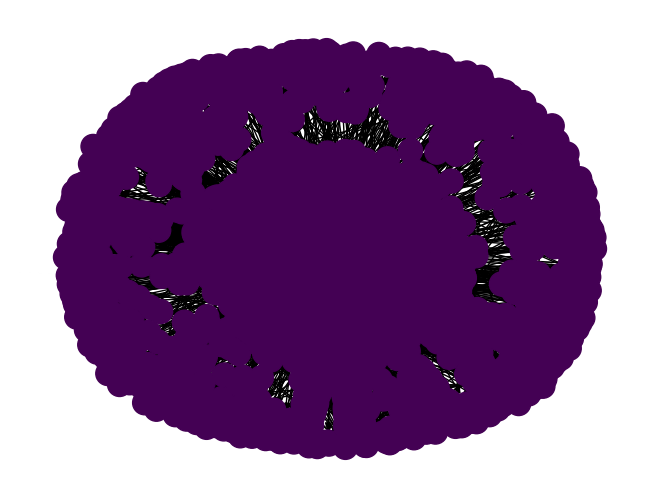

In [6]:
visualise_communities(graph.get_graph(), detector.get_communities())

In [18]:
%time

graph.grow(steps=1000, alpha=0.4, beta=0.2, gamma=0.4, delta_in=1, delta_out=1)
detector.update(graph.get_graph())

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.2 μs
709


In [ ]:
visualise_communities(graph.get_graph(), detector.get_communities())

In [8]:
%time

graph.grow(steps=100)
detector.update(graph.get_graph())

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 7.15 μs
47


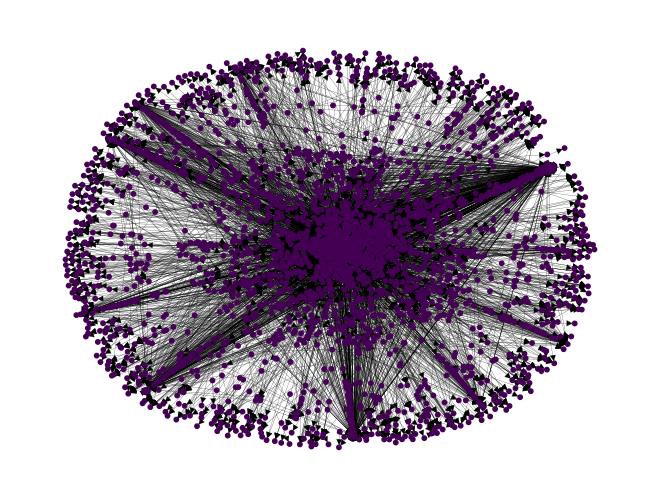

In [9]:
visualise_communities(graph.get_graph(), detector.get_communities())

In [10]:
len(detector.get_communities())

3

In [11]:
[len(c) for c in detector.get_communities()]

[4643, 0, 0]